# Feature Analysis

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- File paths ---
imf_path = "/Users/elliotdable/Documents/PhD/research/fpi_ml/data/imf_data/compiled/omni_imf_data_1990_2025.csv"
geomag_path = "/Users/elliotdable/Documents/PhD/research/fpi_ml/data/geomag_data/solar_geomag_dst_data.csv"

# --- Load datasets ---
imf_df = pd.read_csv(imf_path)
geomag_df = pd.read_csv(geomag_path)

# --- Feature selections ---
IMF_FEATURE_COLS = ['bx_gse_gsm', 'by_gse', 'bz_gse',
'b_vector_rms_sd', 'vx_kms', 'vy_kms', 'vz_kms', 'proton_density',
'proton_temperature', 'al_index', 'au_index']

GEOMAG_FEATURE_COLS = ['hp30', 'ap30', 'dst']

SOLAR_FEATURE_COLS = ['f30', 'f15', 'f10.7', 'f8','f3.2']

ALL_FEATURES = IMF_FEATURE_COLS + GEOMAG_FEATURE_COLS + SOLAR_FEATURE_COLS

In [3]:
geomag_df

,datetime,hp30,ap30,dst,f30,f15,f10.7,f8,f3.2
0,1985-01-01 00:00:00,4.000,27,-24,46.4,54.1,68.3,76.3,254.1
1,1985-01-01 00:30:00,3.333,18,-24,46.4,54.1,68.3,76.3,254.1
2,1985-01-01 01:00:00,3.667,22,-23,46.4,54.1,68.3,76.3,254.1
3,1985-01-01 01:30:00,3.000,15,-23,46.4,54.1,68.3,76.3,254.1
4,1985-01-01 02:00:00,4.333,32,-21,46.4,54.1,68.3,76.3,254.1
...,...,...,...,...,...,...,...,...,...
701275,2024-12-31 21:30:00,3.667,22,-18,142.0,200.0,210.4,206.8,353.6
701276,2024-12-31 22:00:00,3.667,22,-23,142.0,200.0,210.4,206.8,353.6
701277,2024-12-31 22:30:00,5.000,48,-23,142.0,200.0,210.4,206.8,353.6
701278,2024-12-31 23:00:00,4.000,27,-22,142.0,200.0,210.4,206.8,353.6


In [4]:
import pandas as pd
# --- Convert 'datetime' columns to pandas datetime objects ---
imf_df['datetime'] = pd.to_datetime(imf_df['datetime']).dt.tz_localize(None)
geomag_df['datetime'] = pd.to_datetime(geomag_df['datetime']).dt.tz_localize(None)

# --- Set datetime as index ---
imf_df = imf_df.set_index("datetime")
geomag_df = geomag_df.set_index("datetime")

# --- Resample IMF data from 1-min to 30-min resolution ---
# Use mean within each 30-minute window (you could also use median)
imf_resampled = imf_df.resample("30T").mean()

# --- Optionally, align geomag to same time grid (in case of slight mismatches) ---
geomag_resampled = geomag_df.resample("30T").mean()

# --- Merge datasets on time (inner join keeps only overlapping times) ---
merged_df = pd.merge(imf_resampled, geomag_resampled, left_index=True, right_index=True, how="inner")

# --- Check alignment ---
print(merged_df.index.min(), merged_df.index.max())
print("Shape after merge:", merged_df.shape)

# --- Otherwise, just concatenate numerically (assuming aligned) ---
all_features = merged_df[ALL_FEATURES]

# --- Drop any rows with missing data ---
all_features = all_features.dropna()

/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_13664/2751356733.py:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  imf_resampled = imf_df.resample("30T").mean()
/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_13664/2751356733.py:15: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  geomag_resampled = geomag_df.resample("30T").mean()


1990-01-01 00:00:00 2024-12-31 23:30:00
Shape after merge: (613632, 19)


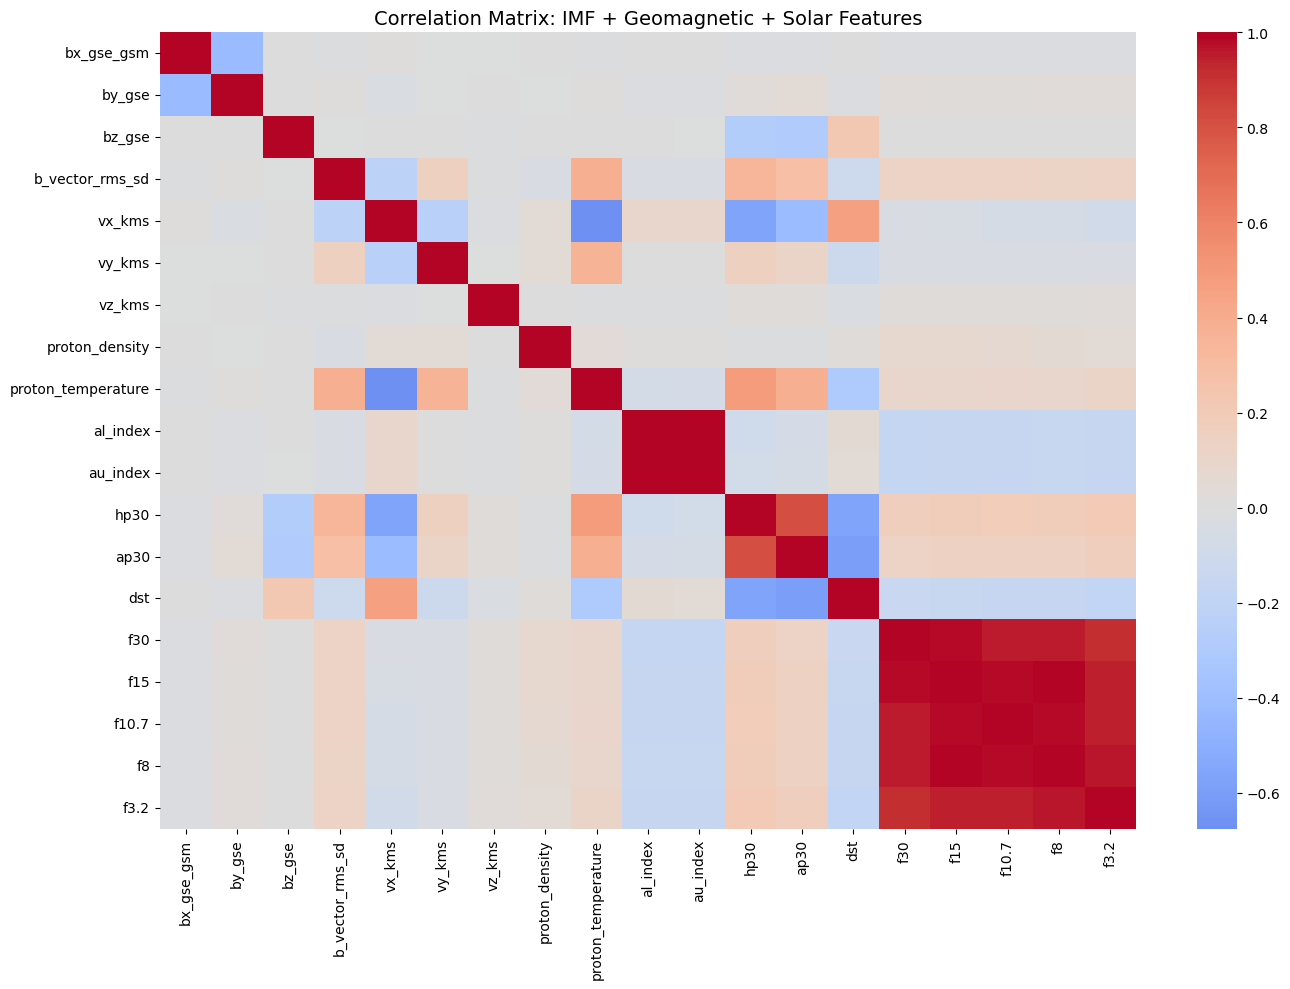

In [5]:
# --- Compute correlation matrix ---
corr_matrix = all_features.corr()

# --- Plot as a heatmap ---
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Matrix: IMF + Geomagnetic + Solar Features", fontsize=14)
plt.tight_layout()
plt.show()

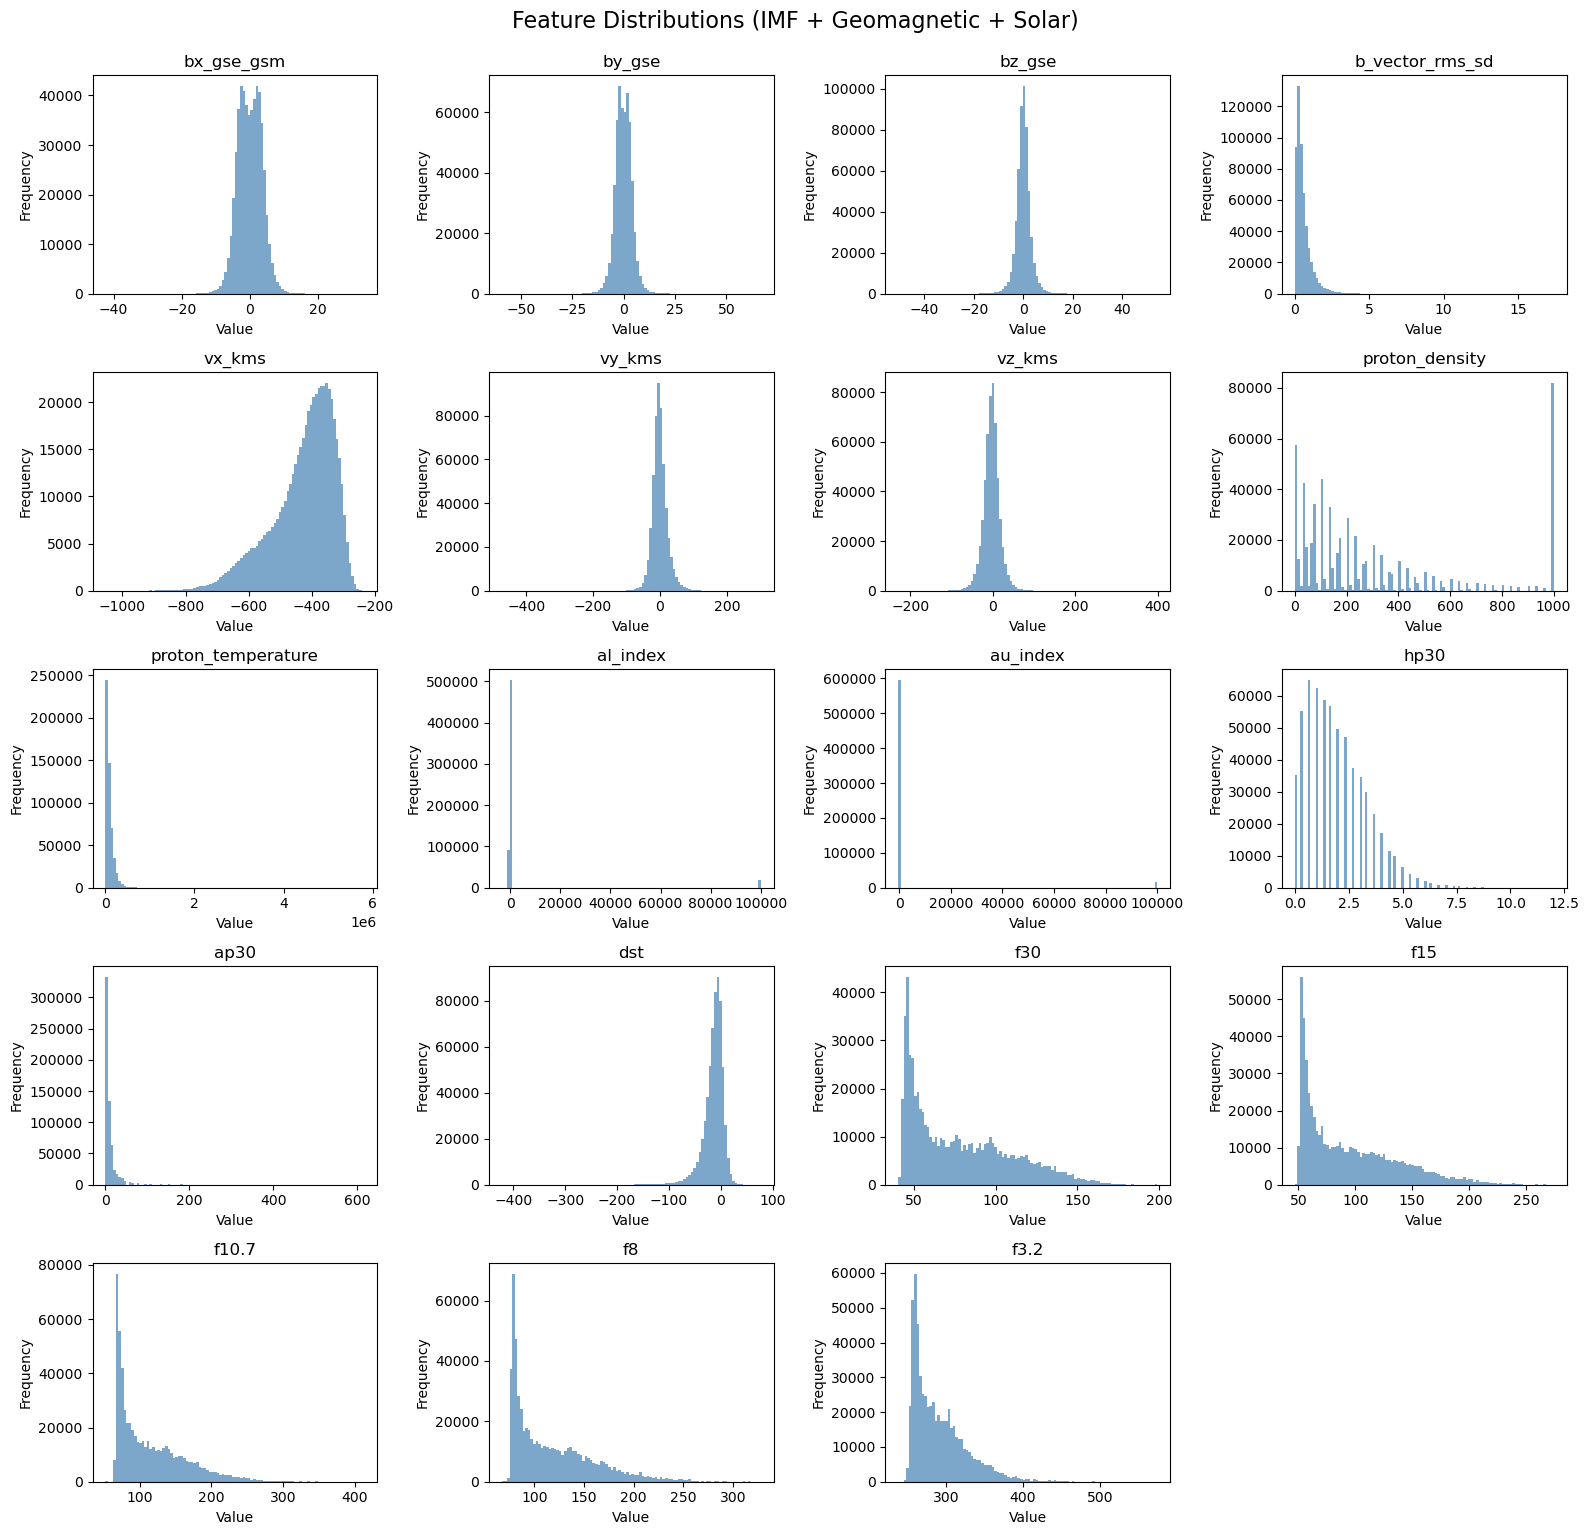

In [6]:
# --- Plot histograms ---
n_cols = 4
n_rows = int(len(ALL_FEATURES) / n_cols) + 1
plt.figure(figsize=(16, n_rows * 3))

for i, col in enumerate(ALL_FEATURES, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.hist(merged_df[col], bins=100, color='steelblue', alpha=0.7)
    plt.title(col)
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.suptitle("Feature Distributions (IMF + Geomagnetic + Solar)", y=1.02, fontsize=16)
plt.show()

Clearly a lot of errors in the IMF data, gonna need to clean that.

Solar and Geomagnetc features seem well distributed, now I need to try to normlise the ditributions in a funky way to ensure scaling is done properly.

## IMF

In [7]:
imf_df.columns, imf_df.dtypes

(Index(['bx_gse_gsm', 'by_gse', 'bz_gse', 'b_vector_rms_sd', 'vx_kms', 'vy_kms',
        'vz_kms', 'proton_density', 'proton_temperature', 'al_index',
        'au_index'],
       dtype='object'),
 bx_gse_gsm            float64
 by_gse                float64
 bz_gse                float64
 b_vector_rms_sd       float64
 vx_kms                float64
 vy_kms                float64
 vz_kms                float64
 proton_density        float64
 proton_temperature    float64
 al_index                int64
 au_index                int64
 dtype: object)

In [8]:
import numpy as np

cols = [
    "datetime", "day", "hour", "minute",
    "bx_gse_gsm", "by_gse", "bz_gse",
    "b_vector_rms_sd", "vx_kms", "vy_kms", "vz_kms",
    "proton_density", "proton_temperature",
    "al_index", "au_index"
]


# --- Replace known fill values (OMNI missing-data flags) with NaN ---
fill_values = [9999, 9999.99, 99999, 99999.9, 999999, 999999.0, 9999999.0, 999.99]
imf_df = imf_df.replace(fill_values, np.nan)

# --- Define physically reasonable limits for each feature ---
limits = {
    "bx_gse_gsm": (-50, 50),       # IMF components (nT)
    "by_gse": (-50, 50),
    "bz_gse": (-50, 50),
    "b_vector_rms_sd": (0, 20),    # RMS field (nT)
    "vx_kms": (-1000, 0),          # Solar wind velocity (km/s)
    "vy_kms": (-300, 300),
    "vz_kms": (-300, 300),
    "proton_density": (0, 100),    # cm^-3
    "proton_temperature": (0, 2e6),# Kelvin
    "al_index": (-3000, 0),        # nT
    "au_index": (0, 2000),         # nT
}

# --- Apply the limits: set out-of-range values to NaN ---
for col, (low, high) in limits.items():
    imf_df.loc[(imf_df[col] < low) | (imf_df[col] > high), col] = np.nan

# --- Option 1: drop rows with any invalid data ---
imf_df_clean = imf_df.dropna(subset=limits.keys())

# --- Option 2 (alternative): interpolate missing values instead ---
# imf_df_clean = imf_df.interpolate(limit_direction='both')

# --- Print a summary ---
print("Original shape:", imf_df.shape)
print("After cleaning:", imf_df_clean.shape)

Original shape: (18430560, 11)
After cleaning: (12172339, 11)


In [ ]:
oct_2003_df

,datetime,altitude,observation_latitude,observation_longitude,temperature,temperature_error,snr
23245,2003-10-26 00:39:16,240.0,70.852417,19.347183,1505.640015,39.290001,6091.0
23249,2003-10-26 00:49:49,240.0,70.852417,19.347183,1571.069946,32.639999,9810.0
23257,2003-10-26 01:14:18,240.0,70.852417,19.347183,1483.469971,35.020000,7419.0
23259,2003-10-26 01:17:46,240.0,70.852417,19.347183,1529.829956,29.650000,11123.0
23261,2003-10-26 01:21:19,240.0,70.852417,19.347183,1520.939941,31.250000,9904.0
...,...,...,...,...,...,...,...
33876,2003-11-01 23:56:44,240.0,67.236069,13.112968,1417.219971,41.299999,4786.0
33877,2003-11-01 23:57:08,240.0,70.852417,19.347183,1496.930054,43.830002,4813.0
33878,2003-11-01 23:58:02,240.0,68.503929,28.947031,1435.829956,36.400002,6339.0
33880,2003-11-01 23:58:54,240.0,65.042969,24.062029,1455.880005,36.490002,6523.0


In [9]:
imf_df_clean.isna().sum()

bx_gse_gsm            0
by_gse                0
bz_gse                0
b_vector_rms_sd       0
vx_kms                0
vy_kms                0
vz_kms                0
proton_density        0
proton_temperature    0
al_index              0
au_index              0
dtype: int64

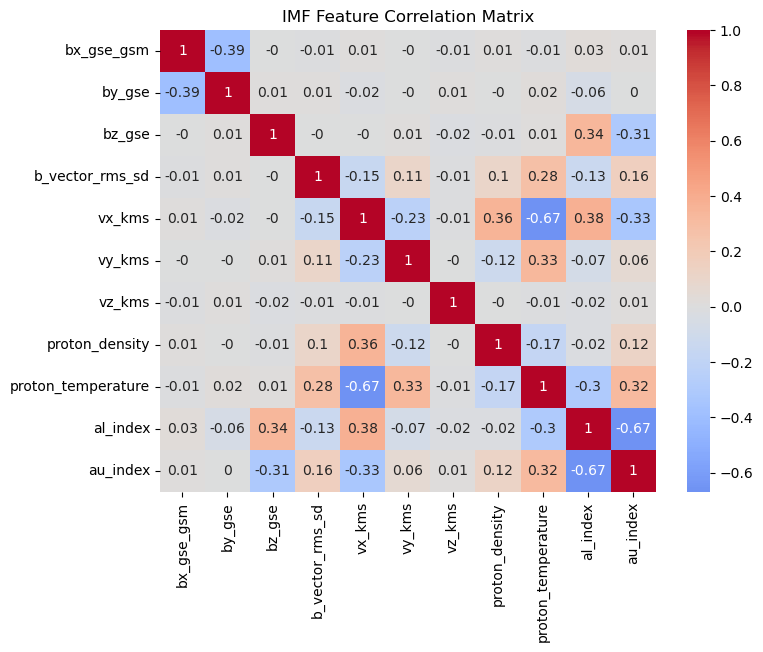

In [10]:
imf_corr = imf_df_clean[IMF_FEATURE_COLS].corr().round(2)

plt.figure(figsize=(8, 6))
sns.heatmap(imf_corr, annot=True, cmap="coolwarm", center=0)
plt.title("IMF Feature Correlation Matrix")
plt.show()

## Geomagnetic and Solar

In [11]:
geomag_df.columns

Index(['hp30', 'ap30', 'dst', 'f30', 'f15', 'f10.7', 'f8', 'f3.2'], dtype='object')

In [12]:
geo_df = geomag_df[GEOMAG_FEATURE_COLS].dropna()
solar_df = geomag_df[SOLAR_FEATURE_COLS].dropna()

geo_corr = geo_df.corr()
solar_corr = solar_df.corr()

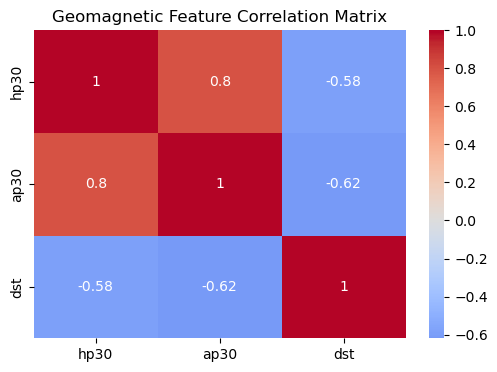

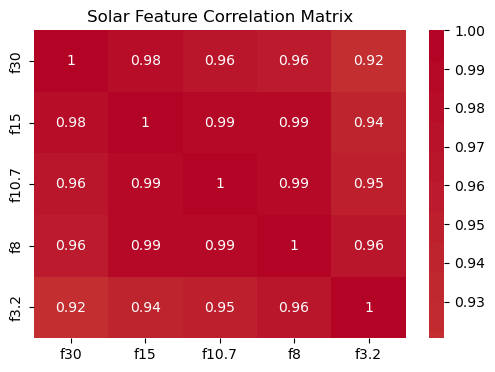

In [13]:
plt.figure(figsize=(6, 4))
sns.heatmap(geo_corr, annot=True, cmap="coolwarm", center=0)
plt.title("Geomagnetic Feature Correlation Matrix")
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(solar_corr, annot=True, cmap="coolwarm", center=0)
plt.title("Solar Feature Correlation Matrix")
plt.show()

Only choosing one geomagnetic and one solar proxy, as they are all highly correlated and would be providing redundant infromation.

## Redoing All Columns

In [14]:
# --- Resample IMF data from 1-min to 30-min resolution ---
# Use mean within each 30-minute window (you could also use median)
imf_resampled = imf_df_clean.resample("30T").mean()

# --- Optionally, align geomag to same time grid (in case of slight mismatches) ---
geomag_resampled = geomag_df.resample("30T").mean()

# --- Merge datasets on time (inner join keeps only overlapping times) ---
merged_df_clean = pd.merge(imf_resampled, geomag_resampled, left_index=True, right_index=True, how="inner")

# --- Check alignment ---
print(merged_df_clean.index.min(), merged_df_clean.index.max())
print("Shape after merge:", merged_df_clean.shape)

# --- Otherwise, just concatenate numerically (assuming aligned) ---
all_features = merged_df_clean[ALL_FEATURES]

# --- Drop any rows with missing data ---
all_features = all_features.dropna()

/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_13664/2450180150.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  imf_resampled = imf_df_clean.resample("30T").mean()


1990-01-01 11:30:00 2024-12-31 23:30:00
Shape after merge: (613609, 19)


/var/folders/pf/x6mn9jt96z14ybg9rxsvmb100000gn/T/ipykernel_13664/2450180150.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  geomag_resampled = geomag_df.resample("30T").mean()


In practise, I'm probably not going to use all of the other solar and geomagentic indices, so I'mn just picking F30, and ap30 as they are proven to be the best at represnting thermopsheric heating, with the highest temporal resolution.

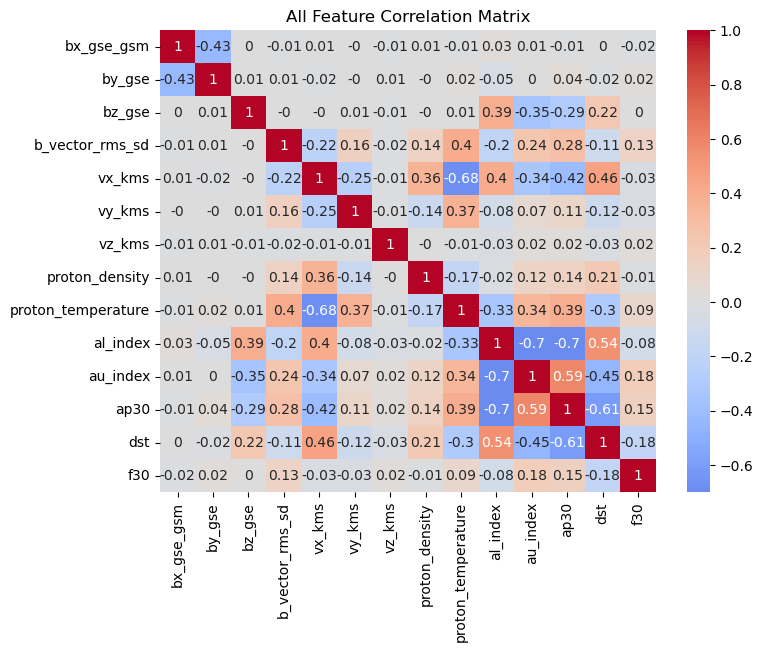

In [16]:
all_corr = merged_df_clean[IMF_FEATURE_COLS + ['ap30', 'dst', 'f30']].corr().round(2)

plt.figure(figsize=(8, 6))
sns.heatmap(all_corr, annot=True, cmap="coolwarm", center=0)
plt.title("All Feature Correlation Matrix")
plt.show()

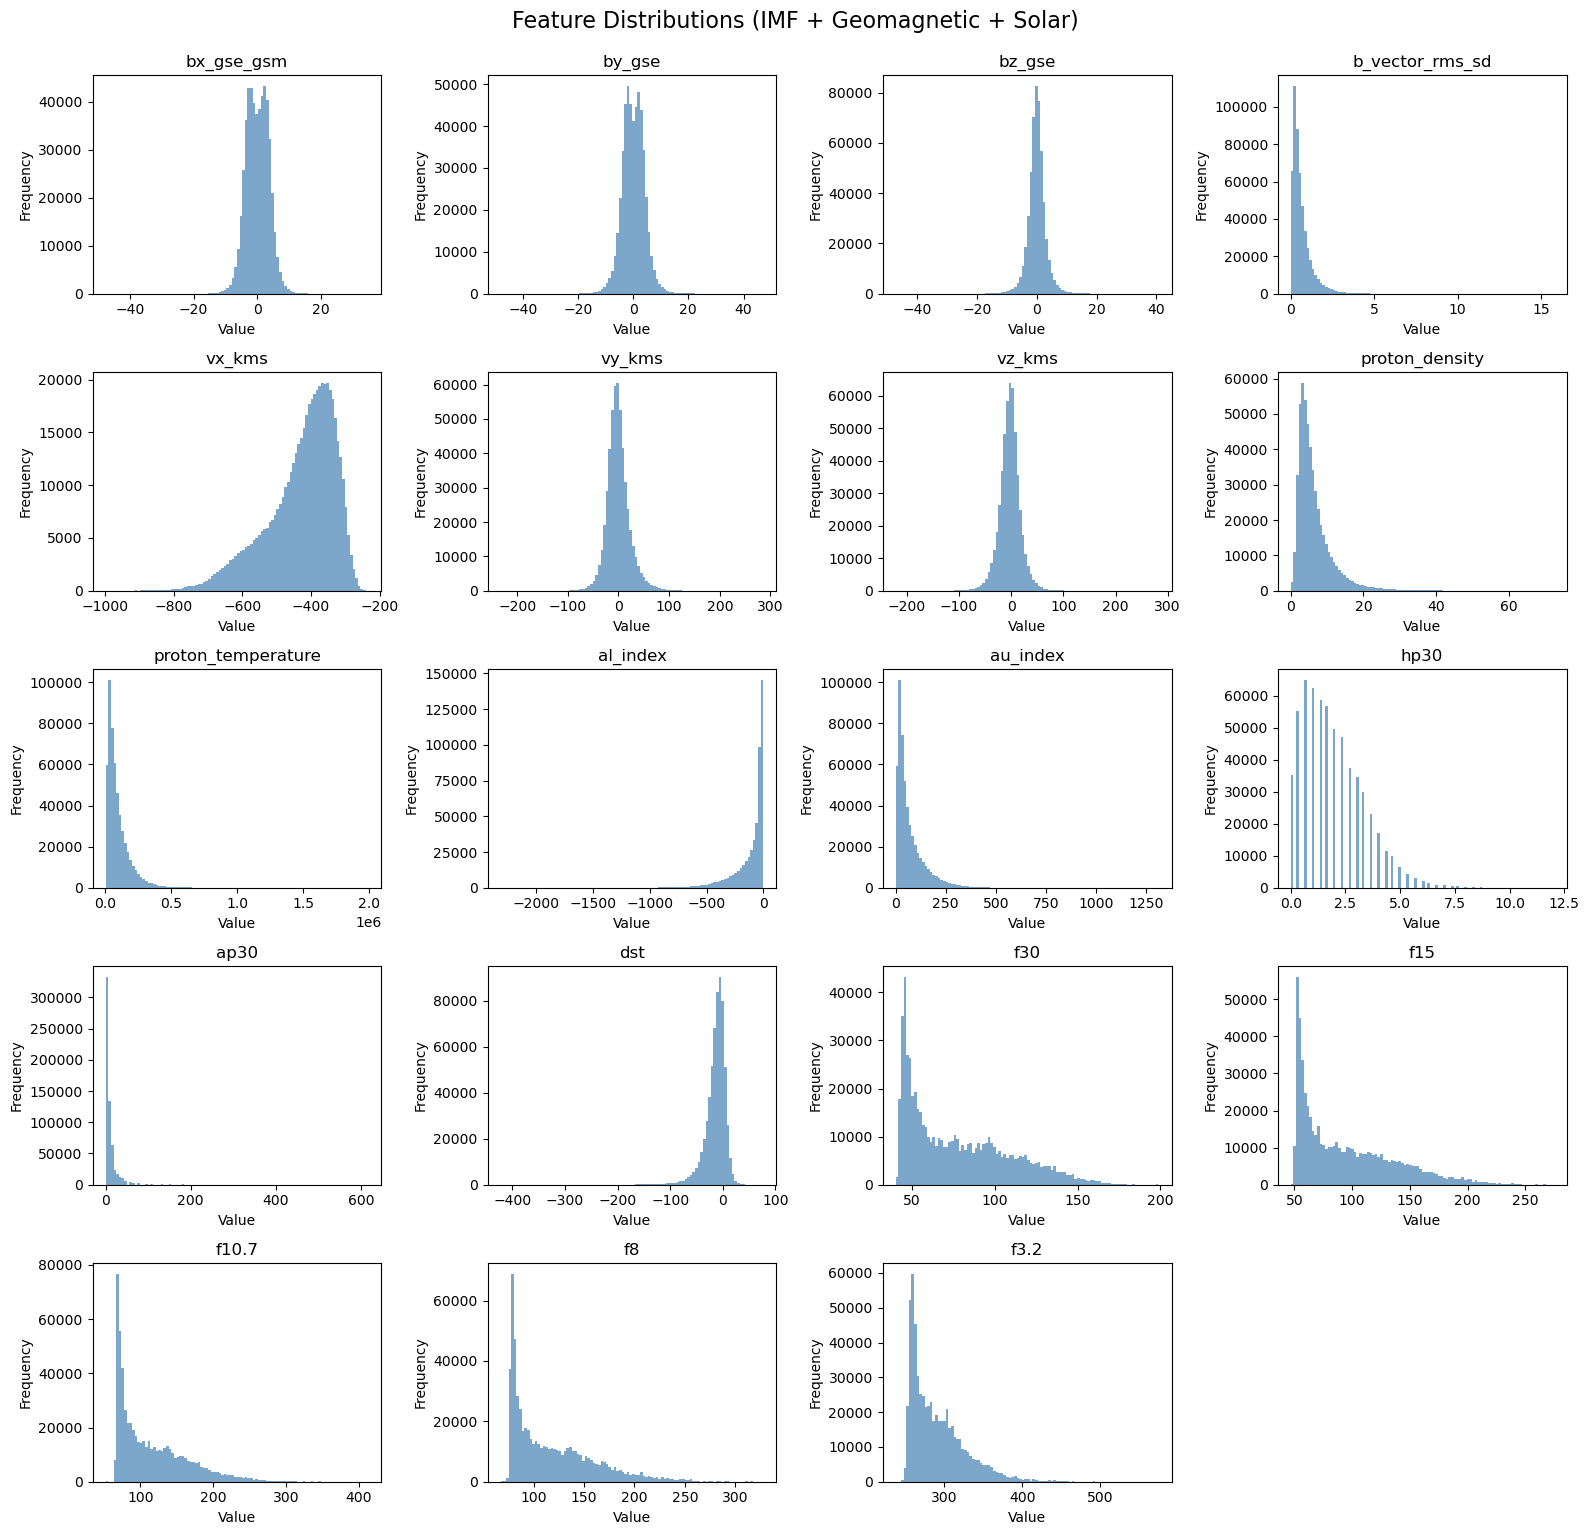

In [17]:
# --- Plot histograms ---
n_cols = 4
n_rows = int(len(ALL_FEATURES) / n_cols) + 1
plt.figure(figsize=(16, n_rows * 3))

for i, col in enumerate(ALL_FEATURES, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.hist(merged_df_clean[col], bins=100, color='steelblue', alpha=0.7)
    plt.title(col)
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.suptitle("Feature Distributions (IMF + Geomagnetic + Solar)", y=1.02, fontsize=16)
plt.show()

- All geomagnetic features are poissson distributed, as well as B_vector and au 
  
- al is inverse poisson

- Bx, By, Bz, Vy, Vz are all normally distributed

- Proton tmperature, Vx, proton_density are normally skewed

In [ ]:
# imf_df_clean.to_csv("/Users/elliotdable/Documents/PhD/research/fpi_ml/data/imf_data/omni_imf_data_1990_2025_cleaned.csv")

In [45]:
imf_df.shape, imf_df_clean.shape

((4294786, 14), (3870396, 14))

In [37]:
pd.read_csv("/Users/elliotdable/Documents/PhD/research/fpi_ml/data/imf_data/compiled/omni_imf_data_1990_2025_cleaned.csv")

,datetime,bx_gse_gsm,by_gse,bz_gse,b_vector_rms_sd,vx_kms,vy_kms,vz_kms,proton_density,proton_temperature,al_index,au_index
0,1999-01-01 00:00:00,-0.93,5.93,-2.95,0.23,-416.1,-29.0,28.6,6.37,89583.0,1,22
1,1999-01-01 00:01:00,-0.84,5.83,-3.20,0.33,-416.1,-29.0,28.6,6.37,89583.0,2,22
2,1999-01-01 00:02:00,-1.45,5.73,-1.59,1.85,-416.1,-29.0,28.6,6.37,89583.0,2,23
3,1999-01-01 00:03:00,-1.49,-2.14,3.37,3.51,-413.3,74.5,2.3,5.25,127573.0,0,25
4,1999-01-01 00:04:00,-1.22,-3.66,5.31,1.09,-413.5,72.9,1.3,5.27,126371.0,-7,26
...,...,...,...,...,...,...,...,...,...,...,...,...
12742745,2014-01-01 23:55:00,-5.33,3.26,2.27,0.88,-549.3,10.8,4.0,6.21,261462.0,-34,96
12742746,2014-01-01 23:56:00,-5.31,3.82,1.22,0.61,-549.3,10.9,4.3,6.22,262527.0,-24,90
12742747,2014-01-01 23:57:00,-4.44,4.26,0.54,2.56,-550.1,9.3,6.4,6.02,268146.0,-56,73
12742748,2014-01-01 23:58:00,-5.46,2.87,-2.82,1.01,-550.3,-1.6,10.4,6.05,260941.0,-75,60
